1. (10 points) Name three popular activation functions. Can you draw 
them?

Activation Function 1: Sigmoid

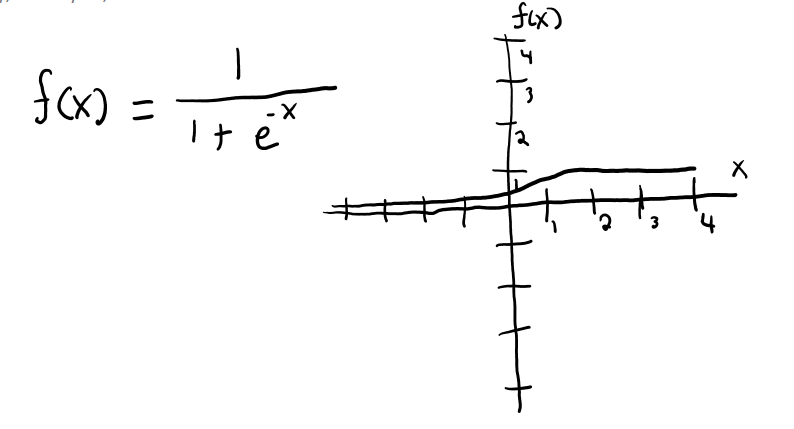

Activation Function 2: Rectified Linear Unit (ReLU)

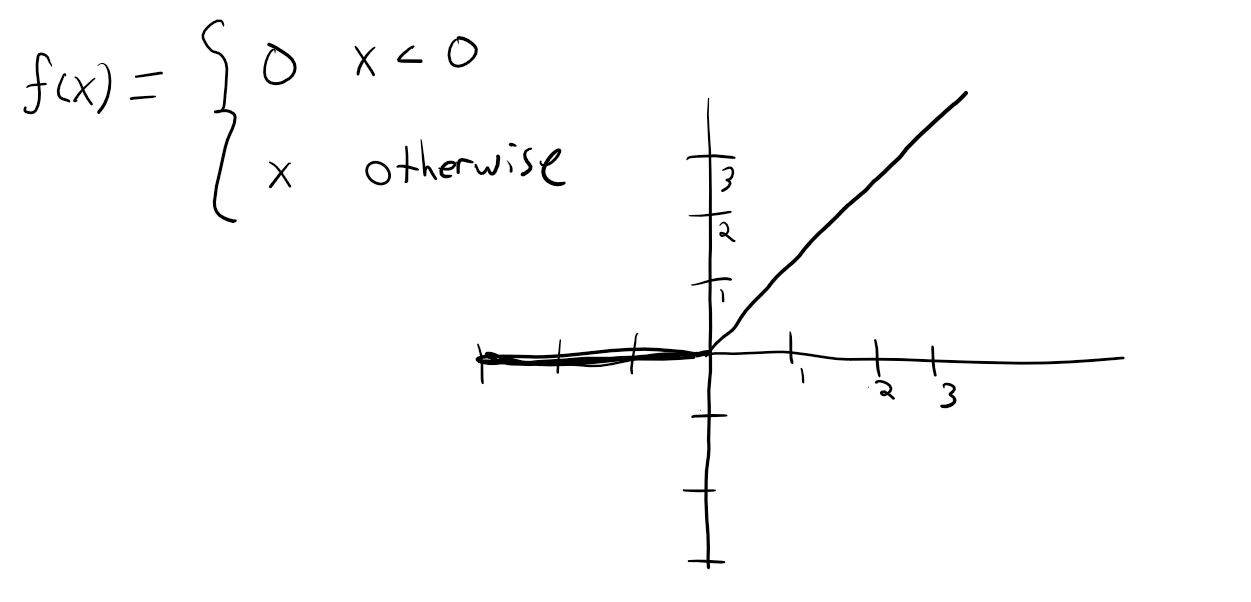

Activation Function 3: Hyperbolic tangent (TanH)

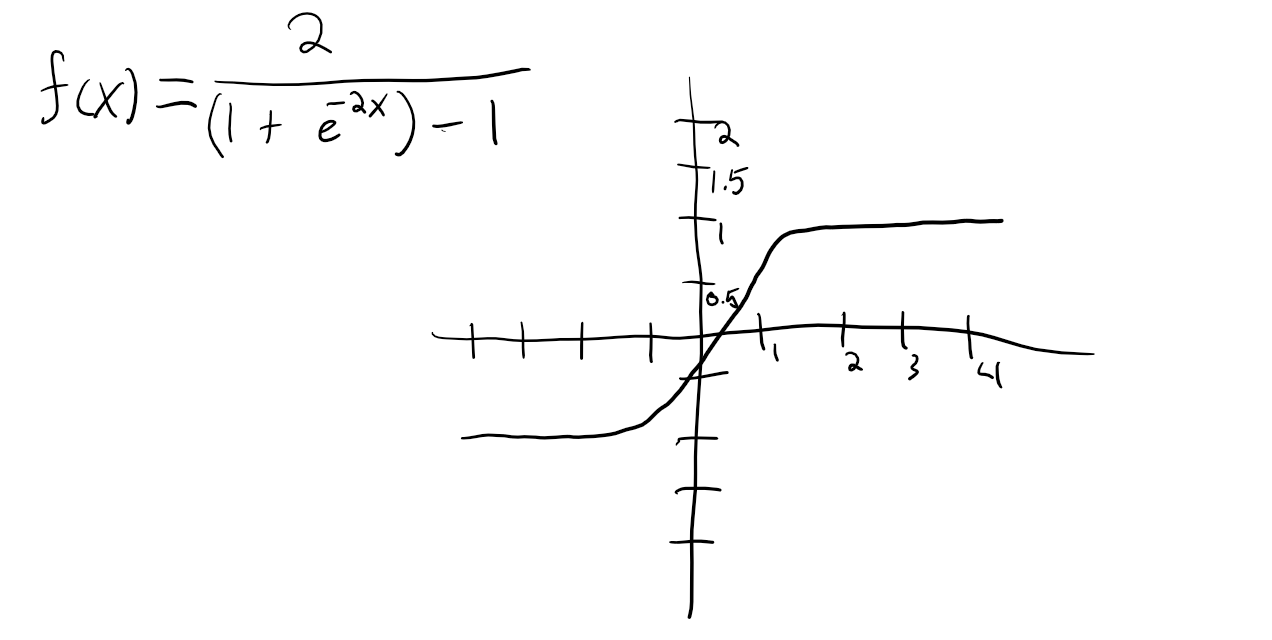

2. (10 points)
a. How many neurons do you need in the output layer if you want to 
classify email into spam or ham? What activation function should you 
use in the output layer?

For any binary classifier, you will need only a single node in the output layer. In the case of a sigmoid activation function, which is preferable, the prediction will output ~1 for spam and ~0 for ham. Since the sigmoid activation function outputs in the range (0,1), any value greater than 0.5 is a prediction of spam and less than 0.5 is a prediction of ham.

b. If instead you want to tackle MNIST, how many neurons do you need 
in the output layer, using what activation function? 

To tackle MNIST, which classifies an image into one of ten numerical digits, there needs to be ten neurons in the output layer. Each neuron represents the prediction for each respective digit from 0 to 9. A preferable activation function for the output layer is softmax because the prediction of each output neuron will sum to one, which is useful to help training converge more quickly as opposed to using sigmoid.

3. (10 points) Can you list all the hyperparameters you can tweak in an 
MLP? If the MLP overfits the training data, how could you tweak these 
hyperparameters to try to solve the problem?

Here are the hyperparameters in a multi-layer perceptron:
1. Number of hidden layers
2. Number of neurons in a layer
3. Activation function in a layer
4. Learning rate ($\lambda$)
5. Number of epochs
6. Loss Function

If the MLP overfits the training data, you can tweak the loss function by adding a regularization penalty. This regularization penalty is applied as a vector norm of the connection weights in the network. To further ensure your model is not overfitting, you can use cross validation.

4. (20 points) Implement Logistic Regression with Mini-batch Gradient 
Descent using TensorFlow or PyTorch. Train it and evaluate it on the 
moons dataset.

The moons dataset is a simple toy dataset to visualize clustering and classification algorithms. Each sample is a 2d point in space with a corresponding binary class label of 1 or 0.

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html


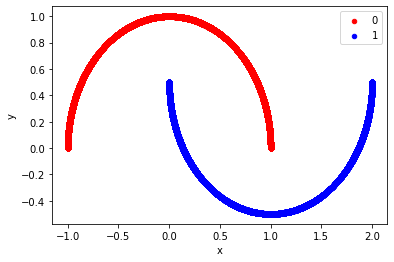

In [138]:
import sklearn.datasets as data
import torch
import pandas as pd
import matplotlib.pyplot as plt
#make 100000 samples
X, y = data.make_moons(100000)

df = pd.DataFrame(dict(x=X[:,0], y=X[:, 1], label = y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

Looking at this data, we can see that there is significant overlap between the two datasets in the x and y direction. Since a simple logistic regression model will find a logit-shaped boundary that separates the two classes, I doubt that a model like this will perform well.

In [139]:
X = torch.from_numpy(X)
y = torch.tensor(y, dtype=torch.float)

In [140]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [141]:
from torch.utils.tensorboard import SummaryWriter
import sys
import numpy as np

class logistic_regression():
    
    def __init__(self, model, optimizer, criterion,  batch_size, epochs, cur_epoch=0, loss=sys.float_info.max):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.batch_size = batch_size
        self.epochs = epochs
        self.cur_epoch = cur_epoch
        self.loss = loss
        self.writer = SummaryWriter()

    def save_model(self, epoch):
        torch.save({
            'epoch': epoch,
            'epochs': self.epochs,
            'model_state_dict': self.model.state_dict(),
            'loss': self.loss,
            'batch_size': self.batch_size,
            'optimizer_state_dict': self.optimizer.state_dict()
            }, 'F:\Git\CSS586\CSS586\Assignments\modelstate.p')
    
    def train(self, X, y):
        for epoch in range(self.cur_epoch, self.epochs):
            
            # X is a torch Variable
            permutation = torch.randperm(X.size()[0])
            
            for i in range(0,X.shape[0], self.batch_size):
                self.optimizer.zero_grad()
                indices = permutation[i:i+self.batch_size]
                batch_x, batch_y = X[indices], y[indices]
                # in case you wanted a semi-full example
                outputs = self.model.forward(batch_x)
                self.loss = self.criterion(torch.squeeze(outputs),batch_y)
                self.loss.backward()
                self.optimizer.step()   
                
            self.writer.add_scalar('Loss/train', self.loss, epoch)
            self.save_model(epoch)


In [10]:
from os.path import exists

class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
            
     def forward(self, x):
         x = x.to(torch.float32)
         outputs = torch.sigmoid(self.linear(x))
         return outputs

model = LogisticRegression(2, 1)    
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)

if exists('F:\Git\CSS586\CSS586\Assignments\modelstate.p'):
    checkpoint = torch.load('F:\Git\CSS586\CSS586\Assignments\modelstate.p')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    logreg = logistic_regression(model, optimizer, criterion, checkpoint['batch_size'], checkpoint['epochs'],
                                 checkpoint['epoch'], checkpoint['loss'])
else:
    batch_size = 1000
    epochs = 100
    logreg = logistic_regression(model, optimizer, criterion, batch_size, epochs)


logreg.train(X_train, y_train)

NameError: name 'torch' is not defined

In [143]:
logreg.model(X_test)

y_pred = logreg.model(X_test)

y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

In [144]:
y_pred = y_pred.cpu().detach().numpy()
y_test = y_test.cpu().detach().numpy()
acc = np.mean(y_pred == y_test)
acc

0.50004998

As discussed above, The logistic regression model is not complex enough to capture the complexity of the signal in the data.

5. (20 points) Train a deep MLP on the MNIST dataset and see if you can 
get over 98% precision. Try adding the bells and whistles like question 4.

In [1]:
import os
MNIST = './samples'
if not os.path.exists(MNIST):
    os.mkdir(MNIST)

In [2]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=MNIST, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=MNIST, train=False, transform=trans, download=True)
type(train_set)

torchvision.datasets.mnist.MNIST

In [3]:
# transform to numpy arrays
X_train = train_set.data.numpy()
y_train = train_set.targets.numpy()
X_test = test_set.data.numpy()
y_test = test_set.targets.numpy()

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_train = X_train.reshape(60000, 784)
X_train.shape

(60000, 784)

In [6]:
X_test.shape

(10000, 28, 28)

In [7]:
X_test = X_test.reshape(10000, 784)
X_test.shape

(10000, 784)

In [8]:
y_train.shape

(60000,)

In [9]:
ytensor = torch.tensor(y_train, dtype=torch.long)

In [10]:
# Neural network module that can accept params we will use in our grid search
import torch.nn as nn
import torch.nn.functional as F

# modules: list of (nn activation funcs or layers) see https://pytorch.org/docs/stable/nn.html
# modules must retain proper input and output shape sequentially
class NetModule(nn.Module):
    def __init__(self, net_modules):
        super(NetModule, self).__init__()
        self.net_modules = nn.Sequential(*net_modules)
        
        
    def forward(self, x):
        x = x.to(torch.float32)
        x = self.net_modules(x)
        return x


In [11]:
# Skorch Callback that prints after each training
from skorch.callbacks import Callback

class PrintLastEpoch(Callback):
    
    def __init__(self):
        super().__init__()
    
    def on_train_end(self, net, **kwargs):
        data = net.history[-1]
        print ("{:<8} {:<15} {:<20} {:<20}".format("Epochs",
                                                   "Training Loss",
                                                   "Validation Loss",
                                                   "Validation Accuracy"))
        print ("{:<8} {:<15} {:<20} {:<20}".format(data['epoch'], 
                                                   data['train_loss'], 
                                                   data['valid_loss'],
                                                   data['valid_acc']))

In [12]:
# Set internal dimensions
input_dim = X_train.shape[1]
output_dim = 10 # number of class labels (0-9)

In [13]:
included_modules = []

# Search ReLU activation with different neurons in hidden layer
[included_modules.append([nn.Linear(input_dim, hidden_dim, bias=False),
                          nn.ReLU(),
                          nn.Linear(hidden_dim, output_dim, bias=False)
                          ]) for hidden_dim in range(50,150,10)]

# Search Sigmoid activation with different neurons in hidden layer
[included_modules.append([nn.Linear(input_dim, hidden_dim, bias=False),
                          nn.Sigmoid(),
                          nn.Linear(hidden_dim, output_dim, bias=False)
                          ]) for hidden_dim in range(50,150,10)]

# Number of architectures
print(len(included_modules))

20


In [14]:
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier
import time
import pickle

# Create sklearn scorer for use in architecture search
precision_scorer = make_scorer(precision_score, average='macro', labels=[0,1,2,3,4,5,6,7,8,9], zero_division=0)

In [ ]:
#initialize skorch NN classifier with default params
net = NeuralNetClassifier(
    NetModule,
    criterion= nn.CrossEntropyLoss(),
    iterator_train__shuffle=True,
    batch_size = 512,
    callbacks=[('Logger', PrintLastEpoch())]
)

net.set_params(callbacks__print_log=None)

In [ ]:
# Perform grid search CV and output the best performing parameters

#parameters to test using gridsearch
params = {
    'lr': [0.01, 0.02], 
    'max_epochs': [20, 30, 40],
    #pass parameters to NetModule constructor to set architecture
    'module__net_modules': included_modules
} 

# Perform grid search with 3-fold cross validation, will refit model at the end using best params on entire training set
gs = GridSearchCV(net, params, refit=True, cv=3, scoring=precision_scorer)

start_time = time.time()
gs.fit(X_train, y_train)
elapsed_time = time.time() - start_time

model_output = (elapsed_time, gs)
pickle.dump( model_output, open( "mnist_model.p", "wb" ) ) 

In [15]:
elapsed, gs = pickle.load( open( "mnist_model.p", "rb" ) )
print("Best Precision: " + str(gs.best_score_) + "\nBest Parameters: " + str(gs.best_params_))

Best Precision: 0.9355607624886856
Best Parameters: {'lr': 0.02, 'max_epochs': 40, 'module__net_modules': [Linear(in_features=784, out_features=140, bias=False), Sigmoid(), Linear(in_features=140, out_features=10, bias=False)]}


In [16]:
print("Training Time: " + '{0:.5}'.format(elapsed) + ' seconds')

Training Time: 5197.7 seconds


In [17]:
y_pred = gs.predict(X_test)

print("Precision on Test Data: " + str(precision_score(y_test, y_pred, 
                                                       average='macro', labels=[0,1,2,3,4,5,6,7,8,9], zero_division=0)))

Precision on Test Data: 0.9492092269941287


Using the same architectures from assignment 1, we observe underfitting from our target 98% precision. Let us try adding complexity to the architectures in our grid search:

In [18]:
included_modules = []

# Search Sigmoid activation with smaller additional hidden layer
[included_modules.append([nn.Linear(input_dim, hidden_dim, bias=False),
                          nn.Sigmoid(),
                          nn.Linear(hidden_dim, 25),
                          nn.Sigmoid(),
                          nn.Linear(25, output_dim, bias=False)
                          ]) for hidden_dim in range(40,160,20)]

# Search Sigmoid activation with larger additional hidden layer
[included_modules.append([nn.Linear(input_dim, 500, bias=False),
                          nn.Sigmoid(),
                          nn.Linear(500, hidden_dim, bias=False),
                          nn.Sigmoid(),
                          nn.Linear(hidden_dim, output_dim, bias=False)
                          ]) for hidden_dim in range(40,160,20)]

# Number of architectures
print(len(included_modules))

12


In [22]:
params = {
    'lr': [0.1, .15], 
    'max_epochs': [40, 60],
    #pass parameters to NetModule constructor to set architecture
    'module__net_modules': included_modules
}

In [23]:
# Perform grid search with 3-fold cross validation, will refit model at the end using best params on entire training set
gs = GridSearchCV(net, params, refit=True, cv=3, scoring=precision_scorer)

start_time = time.time()
gs.fit(X_train, y_train)
elapsed_time = time.time() - start_time

model_output = (elapsed_time, gs)
pickle.dump( model_output, open( "mnist_model_complex.p", "wb" ) ) 

Epochs   Training Loss   Validation Loss      Validation Accuracy 
40       0.29762464928627014 0.329202534198761    0.909375            
Epochs   Training Loss   Validation Loss      Validation Accuracy 
40       0.3066429965496063 0.3264078254699707   0.9085              
Epochs   Training Loss   Validation Loss      Validation Accuracy 
40       0.3093995463848114 0.30510305643081664  0.91875             
Epochs   Training Loss   Validation Loss      Validation Accuracy 
40       0.24720306932926178 0.2837493677139282   0.91975             
Epochs   Training Loss   Validation Loss      Validation Accuracy 
40       0.23992164719104767 0.25703041124343873  0.93                
Epochs   Training Loss   Validation Loss      Validation Accuracy 
40       0.2581090819835663 0.25527714228630066  0.932               
Epochs   Training Loss   Validation Loss      Validation Accuracy 
40       0.20617535257339478 0.23269742918014527  0.933875            
Epochs   Training Loss   Validation L

Epochs   Training Loss   Validation Loss      Validation Accuracy 
60       0.018663758590817453 0.12708796340227127  0.961               
Epochs   Training Loss   Validation Loss      Validation Accuracy 
60       0.017330873310565948 0.11062837815284729  0.965625            
Epochs   Training Loss   Validation Loss      Validation Accuracy 
60       0.017248836100101472 0.11228678703308105  0.966625            
Epochs   Training Loss   Validation Loss      Validation Accuracy 
60       0.017367619119584562 0.1269936729669571   0.96025             
Epochs   Training Loss   Validation Loss      Validation Accuracy 
60       0.017735757440328598 0.11393250489234924  0.96525             
Epochs   Training Loss   Validation Loss      Validation Accuracy 
60       0.016925674423575402 0.10957173550128937  0.967625            
Epochs   Training Loss   Validation Loss      Validation Accuracy 
60       0.017708411782979966 0.1301161031424999   0.960625            
Epochs   Training Loss   Va

Epochs   Training Loss   Validation Loss      Validation Accuracy 
60       0.1567948410511017 0.2034934035539627   0.94                
Epochs   Training Loss   Validation Loss      Validation Accuracy 
60       0.15198597002029418 0.18335475242137908  0.946875            
Epochs   Training Loss   Validation Loss      Validation Accuracy 
60       0.14725772964954376 0.17149880743026732  0.950375            
Epochs   Training Loss   Validation Loss      Validation Accuracy 
60       0.14819131398200988 0.19310871148109435  0.940375            
Epochs   Training Loss   Validation Loss      Validation Accuracy 
60       0.14651039946079253 0.17799505066871643  0.950625            
Epochs   Training Loss   Validation Loss      Validation Accuracy 
60       0.1393804268836975 0.1661057186126709   0.9525              
Epochs   Training Loss   Validation Loss      Validation Accuracy 
60       0.028067556262016298 0.1044863142669201   0.96825             
Epochs   Training Loss   Validation

In [24]:
elapsed, gs = pickle.load( open( "mnist_model_complex.p", "rb" ) )
print("Best Precision: " + str(gs.best_score_) + "\nBest Parameters: " + str(gs.best_params_))

Best Precision: 0.9684387617603502
Best Parameters: {'lr': 0.15, 'max_epochs': 60, 'module__net_modules': [Linear(in_features=784, out_features=500, bias=False), Sigmoid(), Linear(in_features=500, out_features=60, bias=False), Sigmoid(), Linear(in_features=60, out_features=10, bias=False)]}


In [25]:
print("Training Time: " + '{0:.5}'.format(elapsed) + ' seconds')

Training Time: 6581.2 seconds


In [26]:
y_pred = gs.predict(X_test)

print("Precision on Test Data: " + str(precision_score(y_test, y_pred, 
                                                       average='macro', labels=[0,1,2,3,4,5,6,7,8,9], zero_division=0)))

Precision on Test Data: 0.9741431962373014
